In [1]:
import numpy as np
import shapely
import geopandas as gpd
from cartopy.feature import NaturalEarthFeature
import pandas as pd
import xarray as xr
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm
import datetime
import pysumma.plotting as psp
import matplotlib.dates as mdates
from matplotlib.font_manager import FontProperties


def justify(a, invalid_val=np.nan, axis=1, side='right'):
    """
    Justifies a 2D array
    Courtesy: https://stackoverflow.com/questions/44558215/python-justifying-numpy-array/44559180#44559180

    Parameters
    ----------
    A : ndarray
        Input array to be justified
    axis : int
        Axis along which justification is to be made
    side : str
        Direction of justification. It could be 'left', 'right', 'up', 'down'
        It should be 'left' or 'right' for axis=1 and 'up' or 'down' for axis=0.

    """
    if invalid_val is np.nan:
        mask = ~np.isnan(a)
    else:
        mask = a!=invalid_val
    justified_mask = np.sort(mask,axis=axis)
    if (side=='up') | (side=='left'):
        justified_mask = np.flip(justified_mask,axis=axis)
    out = np.full(a.shape, invalid_val)
    if axis==1:
        out[justified_mask] = a[mask]
    else:
        out.T[justified_mask.T] = a.T[mask.T]
    return out

def layers(var, depth, ax=None, colormap='viridis', plot_soil=True,
           plot_snow=True, variable_range=None, add_colorbar=True,
           line_kwargs={}, cbar_kwargs={}):
    """
    Makes a layers plot. Example usage:

    ::

        import pysumma.plotting as psp
        time_range = slice('10-29-2000', '04-30-2001')
        depth    = ds.isel(hru=0).sel(time=time_range)['iLayerHeight']
        temp     = ds.isel(hru=0).sel(time=time_range)['mLayerTemp']
        psp.layers(temp, depth)

    Parameters
    ----------
    var: xr.DataArray
        The variable holding the data to plot.
        Typically begins with ``mLayer``.
    depth: xr.DataArray
        The variable defining the depths of the interfaces
        of each layer. Typically should be ``iLayerHeight``
    ax: Axes
        The axis to plot on. If none is given, a new axis
        will be created
    colormap: string, default='viridis'
        The colormap to use
    plot_soil: boolean, default=True
        Whether to plot the soil domain
    plot_snow: boolean, default=True
        Whether to plot the snow domain
    variable_range: List[float], default=variable range
        The range of numerical values to use. Must be two numbers.
    add_colorbar: boolean, default=True
        Whether to add a colorbar
    line_kwargs: Dict, default={}
        Keyword arguments to pass to ax.vlines.
        These draw the individual layers.
    cbar_kwargs: Dict, default={}
        Keyword arguments to draw the colorbar.
        They are passed directly to plt.colorbar.
    """
    # Preprocess the data
    vmask = var != -9999
    dmask = depth != -9999
    depth.values = justify(depth.where(dmask).values)
    var.values = justify(var.where(vmask).values)
    lo_depth = depth.where(depth > 0).T
    hi_depth = depth.where(depth < 0).T
    if plot_soil and not plot_snow:
        var = var.where((depth > 0).values[:,:-1]).T
    elif plot_snow and not plot_soil:
        var = var.where((depth < 0).values[:,:-1]).T
    else:
        var = var.T
    time = depth.time.values

    # Map colors to full range of data
    if variable_range is not None:
        assert len(variable_range) == 2, 'variable_range must have 2 values!'
        norm = plt.Normalize(variable_range[0], variable_range[1])
    else:
        norm = plt.Normalize(np.nanmin(var), np.nanmax(var))
    cmap = mpl.cm.get_cmap(colormap)
    rgba = cmap(norm(var))

    # Create axes if needed
    if not ax:
        fig, ax = plt.subplots(figsize=(18,8))

    # Plot soil layers - need to reverse because we plot bottom down
    if plot_soil:
        for l in lo_depth.ifcToto.values[:-1][::-1]:
            y = lo_depth[l]
            y[np.isnan(y)] = 0
            ax.vlines(time, ymin=-y, ymax=0, color=rgba[l], **line_kwargs)

    # Plot snow layers - plot top down
    if plot_snow:
        for l in hi_depth.ifcToto.values[:-1]:
            y = hi_depth[l]
            y[np.isnan(y)] = 0
            if (y != 0).any():
                ax.vlines(time, ymin=0, ymax=-y, color=rgba[l], **line_kwargs)

    # Add the colorbar
    mappable = cm.ScalarMappable(norm=norm, cmap=cmap)
    mappable.set_array(var.values.flatten())
    try:
        label = var.long_name
    except:
        label = var.name
    if 'label' not in cbar_kwargs.keys():
        cbar_kwargs['label'] = label
    if 'ax' not in cbar_kwargs.keys():
        cbar_kwargs['ax'] = ax
    if add_colorbar:
        cbar = plt.gcf().colorbar(mappable, **cbar_kwargs)
        cbar.ax.tick_params(labelsize=12, labelcolor='black', labelrotation=0, width=1.5)  # Customize tick parameters
        for tick in cbar.ax.get_yticklabels():
            tick.set_fontweight('bold')  # Set tick labels to bold
        cbar.set_label(cbar_kwargs['label'], fontsize=15, fontweight='bold')  # Set label to bold and size 15
    return ax, mappable

In [2]:
ds = xr.open_dataset('/home/cdalden/summa_setup/model/output/output_olallie_current_WY24_timestep.nc')

In [3]:
file_name = 'olallie_current_WY24'
ds = xr.open_dataset(f'/home/cdalden/summa_setup/model/output/output_{file_name}_timestep.nc')

time_range = slice('12-01-2023', '03-01-2024')
depth      =    ds.isel(hru=0).sel(time=time_range)['iLayerHeight']
temp       =    ds.isel(hru=0).sel(time=time_range)['mLayerTemp']
temp       =    temp.where((temp == -9999) | np.isnan(temp), temp - 273.15)
frac_liq   =    ds.isel(hru=0).sel(time=time_range)['mLayerVolFracLiq']
frac_wat   =    ds.isel(hru=0).sel(time=time_range)['mLayerVolFracWat']
frac_wat   =    frac_wat.where((frac_wat == -9999) | np.isnan(frac_wat), frac_wat * 1000)
snow_depth =    ds.isel(hru=0).sel(time=time_range)['scalarSnowDepth']

/tmp/ipykernel_25406/324911838.py:109: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl.cm.get_cmap(colormap)


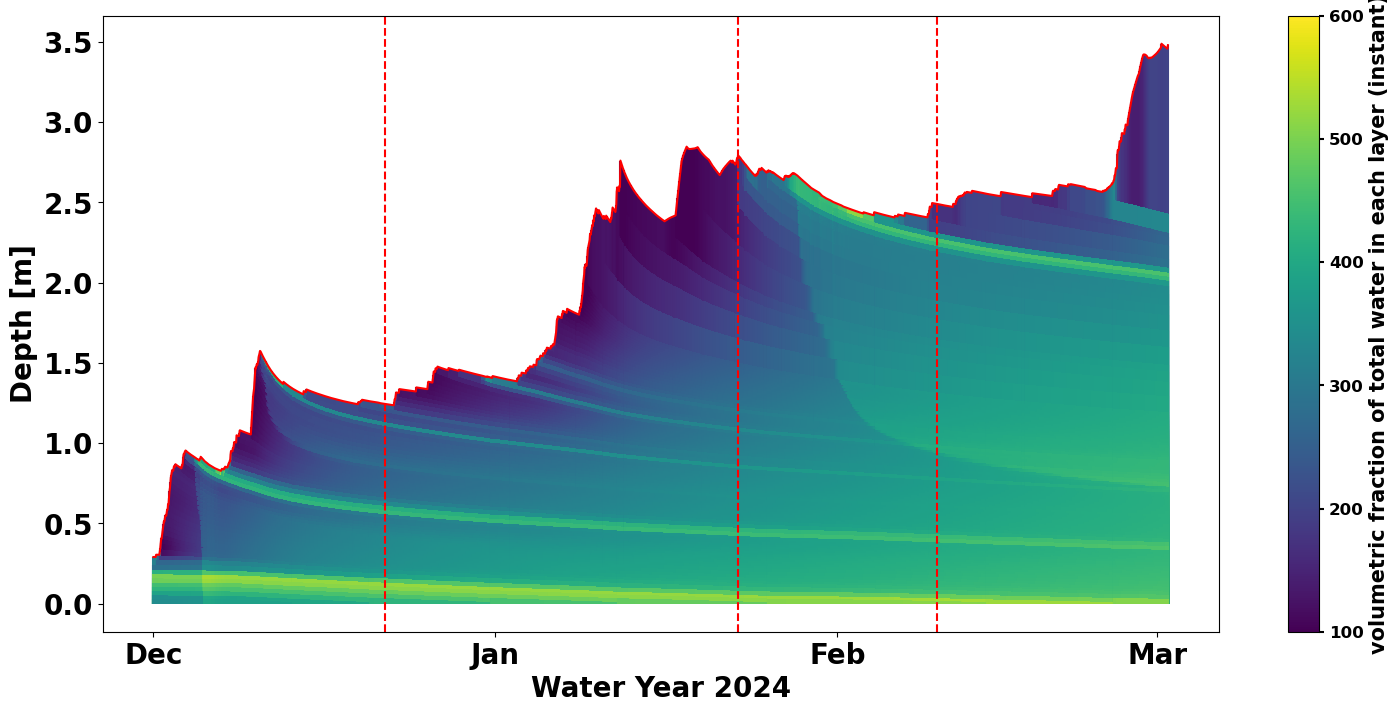

In [15]:
# cbar_kwargs = {'label': 'Density [kg m-3]', 'labelsize': 20, 'labelweight': 'bold'}

fig, ax = plt.subplots(figsize=(18,8))
layers(frac_wat, depth, plot_soil=False, variable_range=[100,600], ax=ax)
ax.plot(snow_depth.time, snow_depth, c='r')
ax.set_xlabel('Water Year 2024', fontweight='bold', fontsize=20)
ax.set_ylabel('Depth [m]', fontweight='bold', fontsize=20)
ax.axvline(datetime.datetime(2024, 1, 23), color='r', linestyle='--')
ax.axvline(datetime.datetime(2023, 12, 22), color='r', linestyle='--')
ax.axvline(datetime.datetime(2024, 2, 10), color='r', linestyle='--')

# Set the date format for x-axis
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
# Ensure each month is only plotted once
ax.xaxis.set_major_locator(mdates.MonthLocator())

# Change the fontsize and fontweight of x tick labels
font_properties = FontProperties(weight='bold', size=20)
for label in ax.get_xticklabels() + ax.get_yticklabels():
    label.set_fontproperties(font_properties)

plt.savefig(f'/home/cdalden/summa_setup/analysis/figures/{file_name}_density.png', dpi=300, bbox_inches='tight')

/tmp/ipykernel_30917/324911838.py:109: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl.cm.get_cmap(colormap)


AttributeError: 'Axes' object has no attribute 'ax'

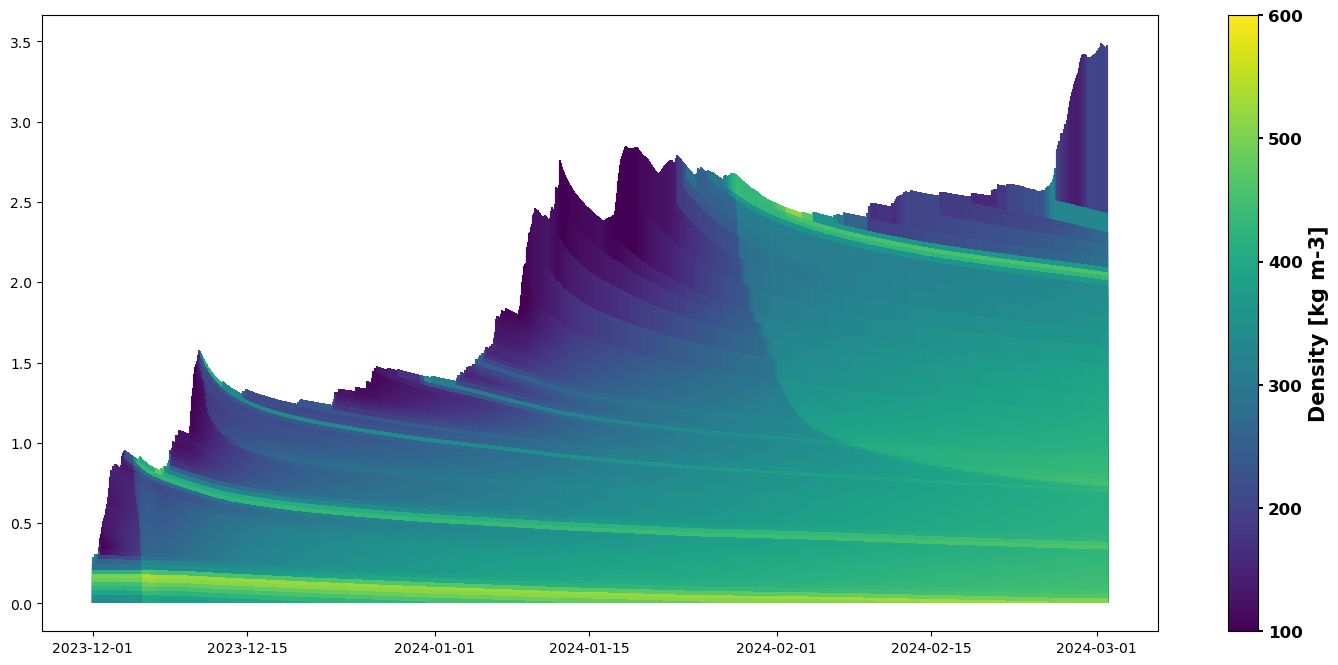

In [7]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.font_manager import FontProperties
import datetime

# Define cbar_kwargs with label
cbar_kwargs = {'label': 'Density [kg m-3]'}

fig, ax = plt.subplots(figsize=(18, 8))

# Assuming layers returns a tuple and the first element is the colorbar
cbar, _ = layers(frac_wat, depth, plot_soil=False, variable_range=[100, 600], ax=ax, cbar_kwargs=cbar_kwargs)

# Set the colorbar label
cbar.set_label('Density [kg m-3]')

# Set the colorbar label font properties
cbar.ax.yaxis.label.set_size(50)
cbar.ax.yaxis.label.set_weight('bold')

# Set the tick label font properties
cbar.ax.tick_params(labelsize=50, labelweight='bold')

# Plot additional data
ax.plot(snow_depth.time, snow_depth, c='r')
ax.set_xlabel('Water Year 2024', fontweight='bold', fontsize=20)
ax.set_ylabel('Depth [m]', fontweight='bold', fontsize=20)
ax.axvline(datetime.datetime(2024, 1, 23), color='r', linestyle='--')
ax.axvline(datetime.datetime(2023, 12, 22), color='r', linestyle='--')
ax.axvline(datetime.datetime(2024, 2, 10), color='r', linestyle='--')

# Set the date format for x-axis
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
# Ensure each month is only plotted once
ax.xaxis.set_major_locator(mdates.MonthLocator())

# Change the fontsize and fontweight of x tick labels
font_properties = FontProperties(weight='bold', size=20)
for label in ax.get_xticklabels() + ax.get_yticklabels():
    label.set_fontproperties(font_properties)

# plt.savefig(f'/home/cdalden/summa_setup/analysis/figures/{file_name}_density.png', dpi=300, bbox_inches='tight')

/tmp/ipykernel_27555/2626403901.py:107: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl.cm.get_cmap(colormap)


Text(0.5, 1.0, 'CSSL Modeled Snow Depth and Temperature - WY24')

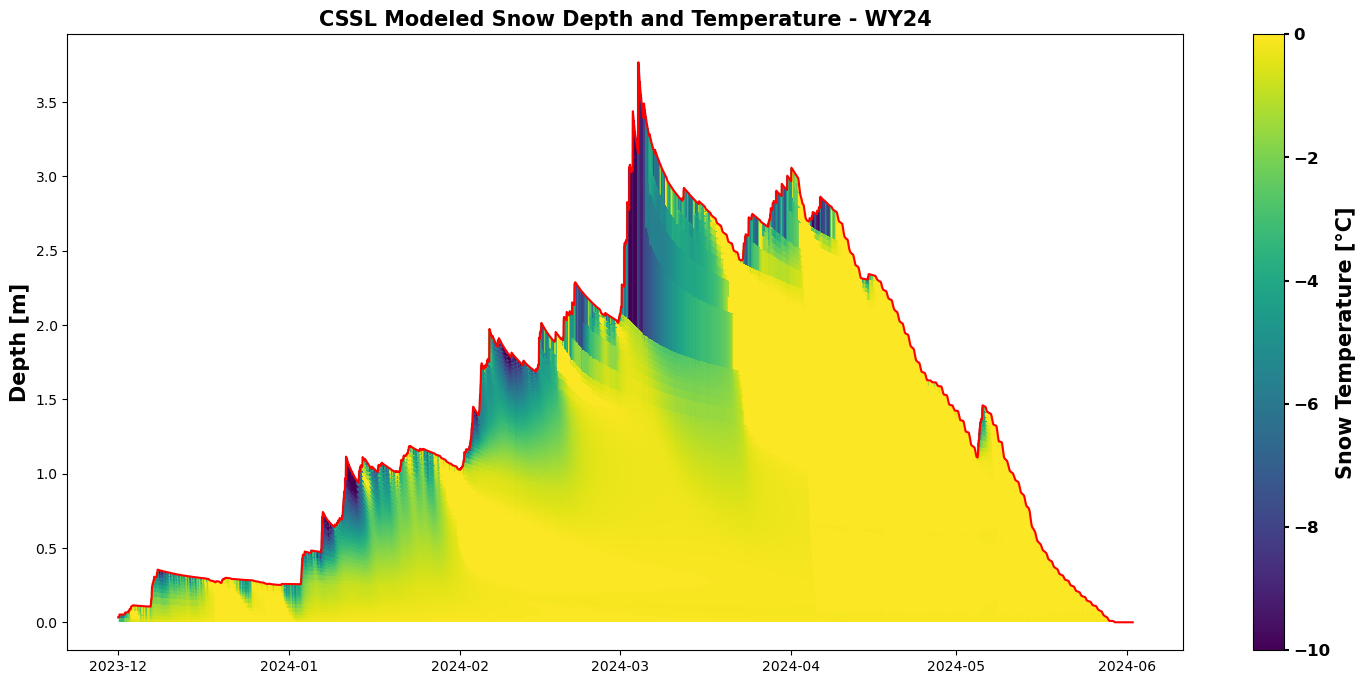

In [13]:
cbar_kwargs = {'label': 'Snow Temperature [°C]'}

layers(temp, depth, plot_soil=False, variable_range=[-10, 0], cbar_kwargs=cbar_kwargs)
plt.plot(snow_depth.time, snow_depth, c='r')

plt.ylabel('Depth [m]', fontweight='bold', fontsize=15)
plt.title('CSSL Modeled Snow Depth and Temperature - WY24', fontweight='bold', fontsize=15)